now working /home/ken/src/github.com/endaaman/bt



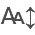

In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
from sklearn.decomposition import PCA
import ipynbname
from endaaman.ml import fix_global_seed
from itables import init_notebook_mode
# from ydata_profiling import ProfileReport

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)

DPI = 300

sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 
plt.rcParams['figure.dpi'] = DPI

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

init_notebook_mode(all_interactive=True)
# print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

In [11]:
df = pd.read_excel('out/compare/LMGAOB/fold5_0/frozen_uni_500/integrated_umap_embeddings.xlsx')
# df = df[df['Diagnosis'] == 'M']
# df = 
for name, rows in df.groupby('Diagnosis'):
    r1 = rows[rows['Dataset'] == 'Local']
    r2 = rows[rows['Dataset'] != 'Local']
    print(name, len(rows['name'].unique()), len(rows), 'cv', len(r1['name'].unique()), len(r1), 'EB', len(r2['name'].unique()), len(r2), )
    # display(_rows.iloc[:4])

A 123 1464 cv 6 300 EB 117 1164
B 29 1450 cv 29 1450 EB 0 0
G 113 1646 cv 13 650 EB 100 996
L 70 1117 cv 11 529 EB 59 588
M 63 1260 cv 16 800 EB 47 460
O 90 1098 cv 5 250 EB 85 848


In [16]:
data = torch.load('out/compare/LMGAOB/fold5_0/frozen_uni_500/features_ebrains.pt')

In [17]:
data[0]

{'name': 'a19852f7-357f-11eb-9a9f-001a7dda7111',
 'path': 'data/EBRAINS/cache/L/a19852f7-357f-11eb-9a9f-001a7dda7111/3-0_5-0.png',
 'diag_org': 'L',
 'pred': 'L',
 'feature': array([ 1.46952,  2.19046, -1.57392, ...,  0.25444, -0.78873, -0.49369],
       dtype=float32)}

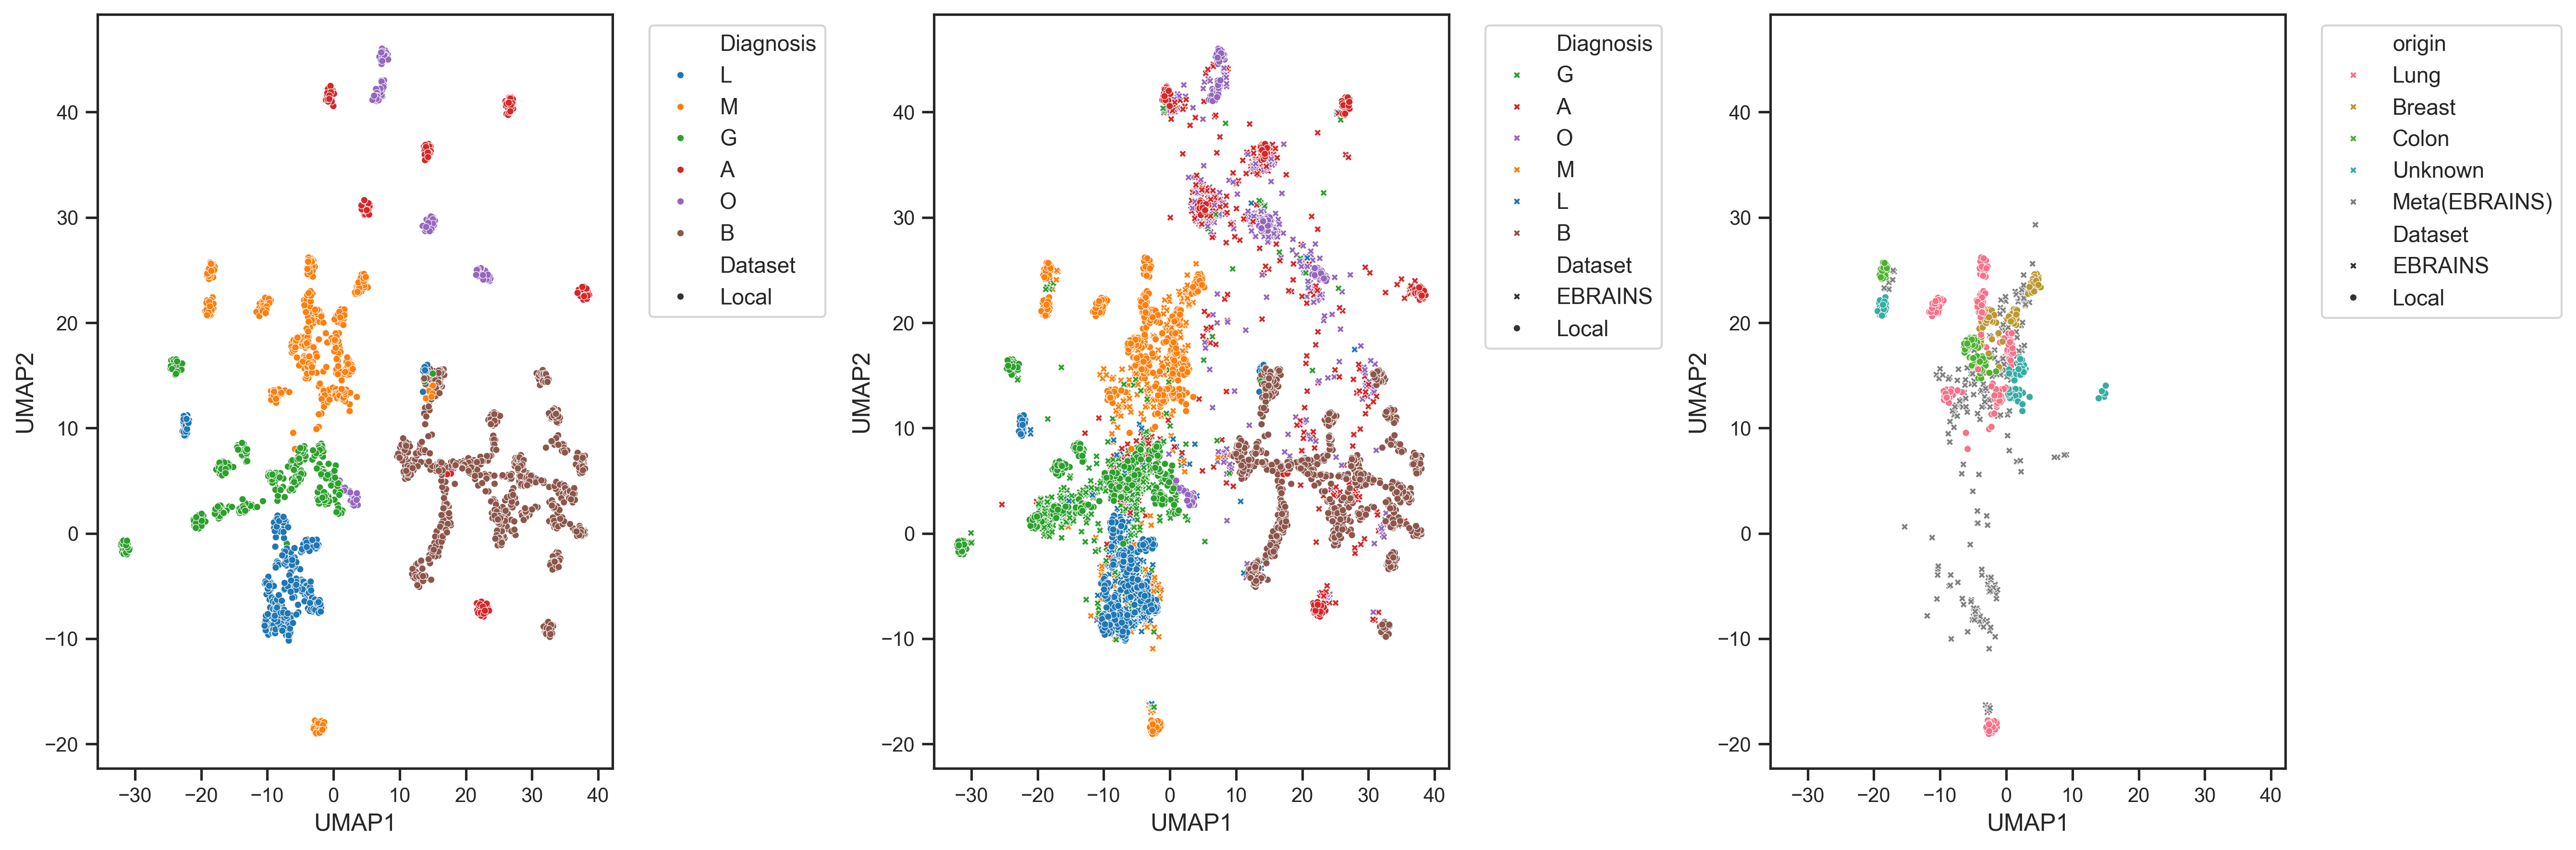

In [20]:
def cluster(path, mode='label', show_cv=False):
    df = pd.read_excel(path)
    # unique_codes = list(df['Diagnosis'].unique())
    unique_codes = list('LMGAOB')

    show_cv = True
    
    if mode == 'multi':
        if show_cv:
            fig = plt.figure(figsize=(18, 6))
            ax_cv = fig.add_subplot(1, 3, 1)
            ax_label = fig.add_subplot(1, 3, 2)
            ax_origin = fig.add_subplot(1, 3, 3)
        else:
            fig = plt.figure(figsize=(14, 6))
            ax_label = fig.add_subplot(1, 2, 1)
            ax_origin = fig.add_subplot(1, 2, 2)
    else:
        fig = plt.figure(figsize=(8, 6))
        ax_label = fig.add_subplot(1, 1, 1)
        ax_origin = ax_label

    if mode in ['label', 'multi']:
        g = sns.scatterplot(
            data=df[::-1],
            x='UMAP1', y='UMAP2',
            hue='Diagnosis',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            hue_order=unique_codes,
            palette='tab10',
            s=12,
            # alpha=0.3,
            ax=ax_label,
        )
        handles, labels = ax_label.get_legend_handles_labels()
        order = [0, 3, 4, 5, 2, 1, 6, 7, 8, 9]
        ax_label.legend([handles[i] for i in order], [labels[i] for i in order], bbox_to_anchor=(1.05, 1), loc='upper left')
        if show_cv:
            g = sns.scatterplot(
                data=df[df['Dataset'] == 'Local'],
                x='UMAP1', y='UMAP2',
                hue='Diagnosis',
                style='Dataset',  
                markers={'Local': 'o'}, 
                hue_order=unique_codes,
                palette='tab10',
                s=12,
                # alpha=0.3,
                ax=ax_cv,
            )
            ax_cv.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax_cv.set_xlim(*ax_label.get_xlim())
            ax_cv.set_ylim(*ax_label.get_ylim())
    if mode in ['origin', 'multi']:
        origin_count = len(df['origin'].unique())
        pallete = list(sns.color_palette('husl'))[:origin_count-2]+['gray']
        g = sns.scatterplot(
            data=df[::-1],
            x='UMAP1', y='UMAP2',
            hue='origin',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            hue_order=['Lung', 'Breast', 'Colon', 'Unknown', 'Meta(EBRAINS)'],
            palette=pallete,
            s=12,
            # alpha=0.7,
            ax=ax_origin,
        )
        ax_origin.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax_origin.set_xlim(*ax_label.get_xlim())
        ax_origin.set_ylim(*ax_label.get_ylim())
        
    plt.tight_layout()
    plt.show()

# UNI(LP)
cluster(
    'out/compare/LMGAOB/fold5_0/frozen_uni_500/integrated_umap_embeddings.xlsx',
    mode = 'multi',
)

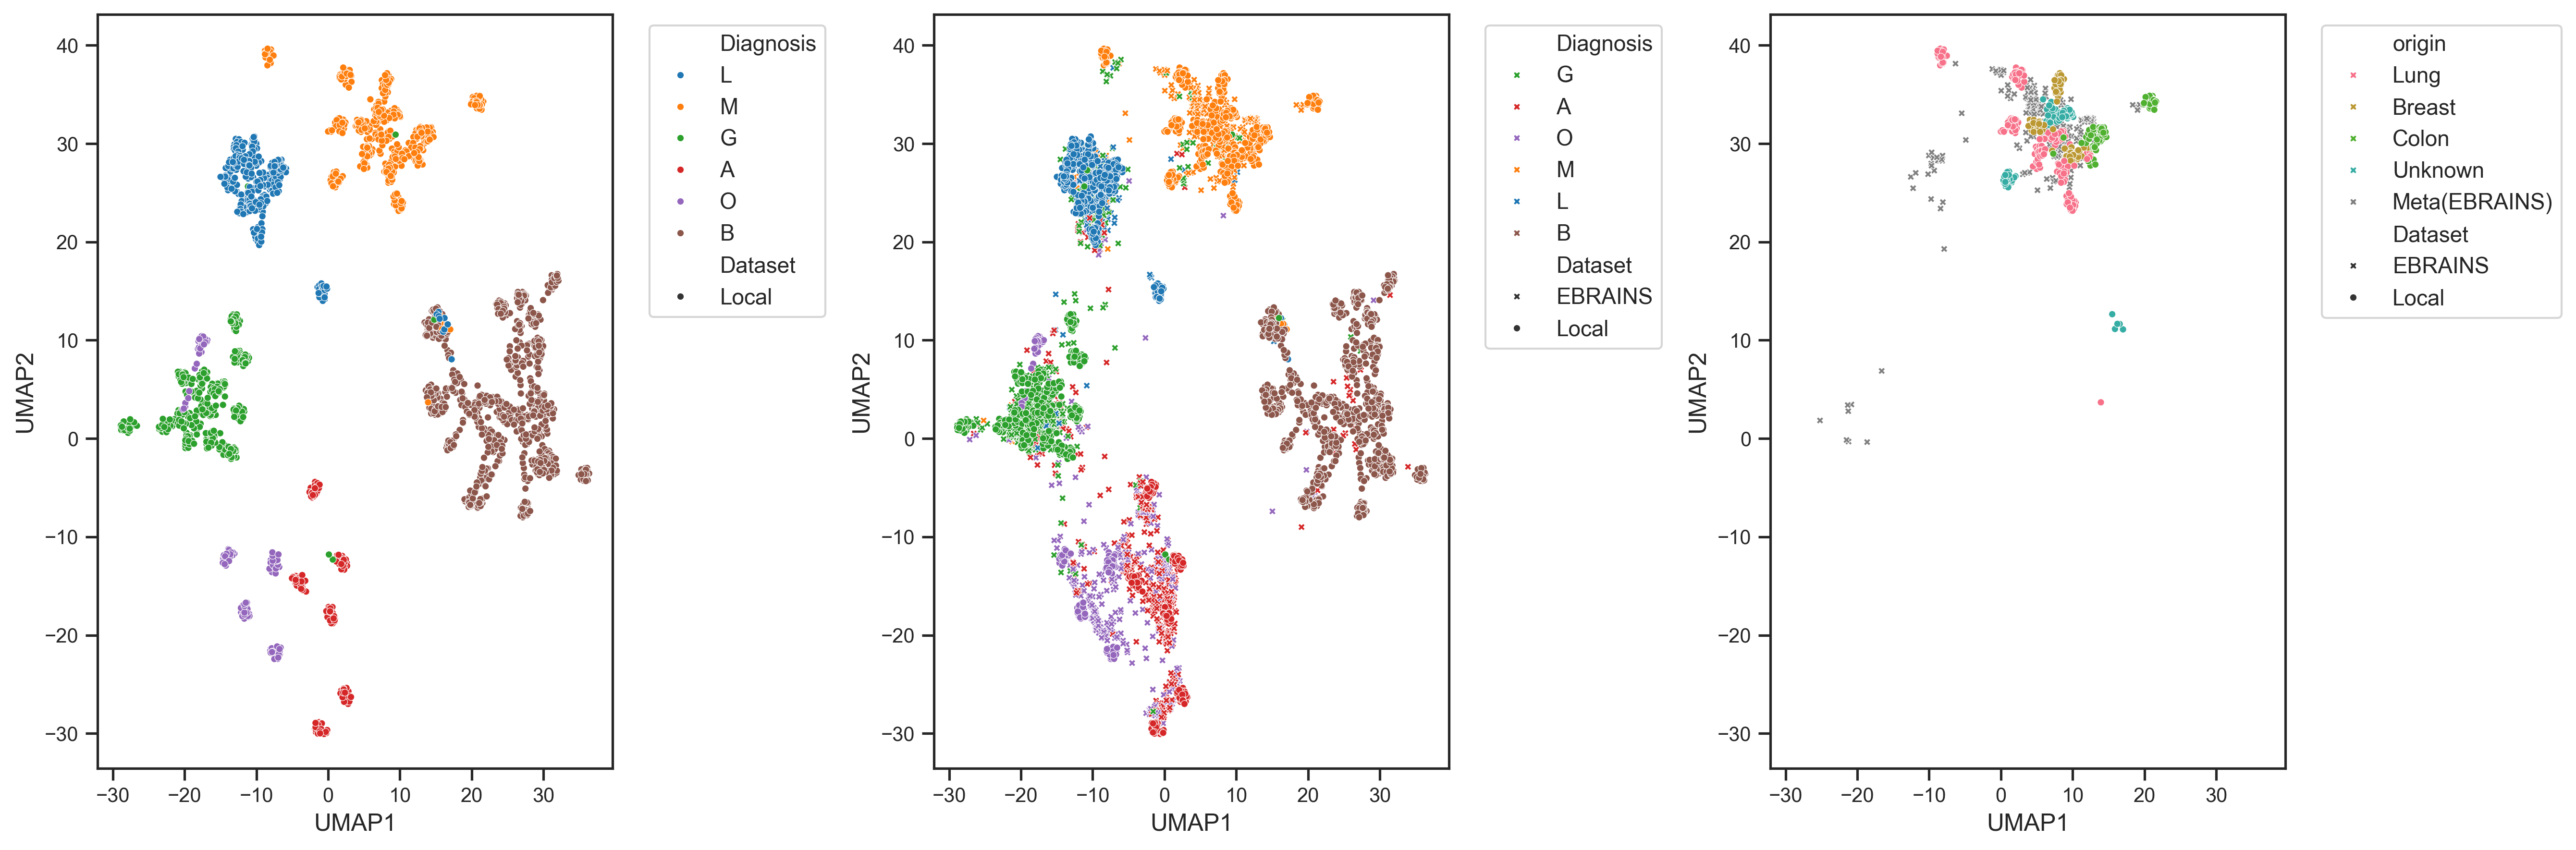

In [21]:
# UNI(LP)
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_uni_500/integrated_umap_embeddings.xlsx',
    mode = 'multi',
)

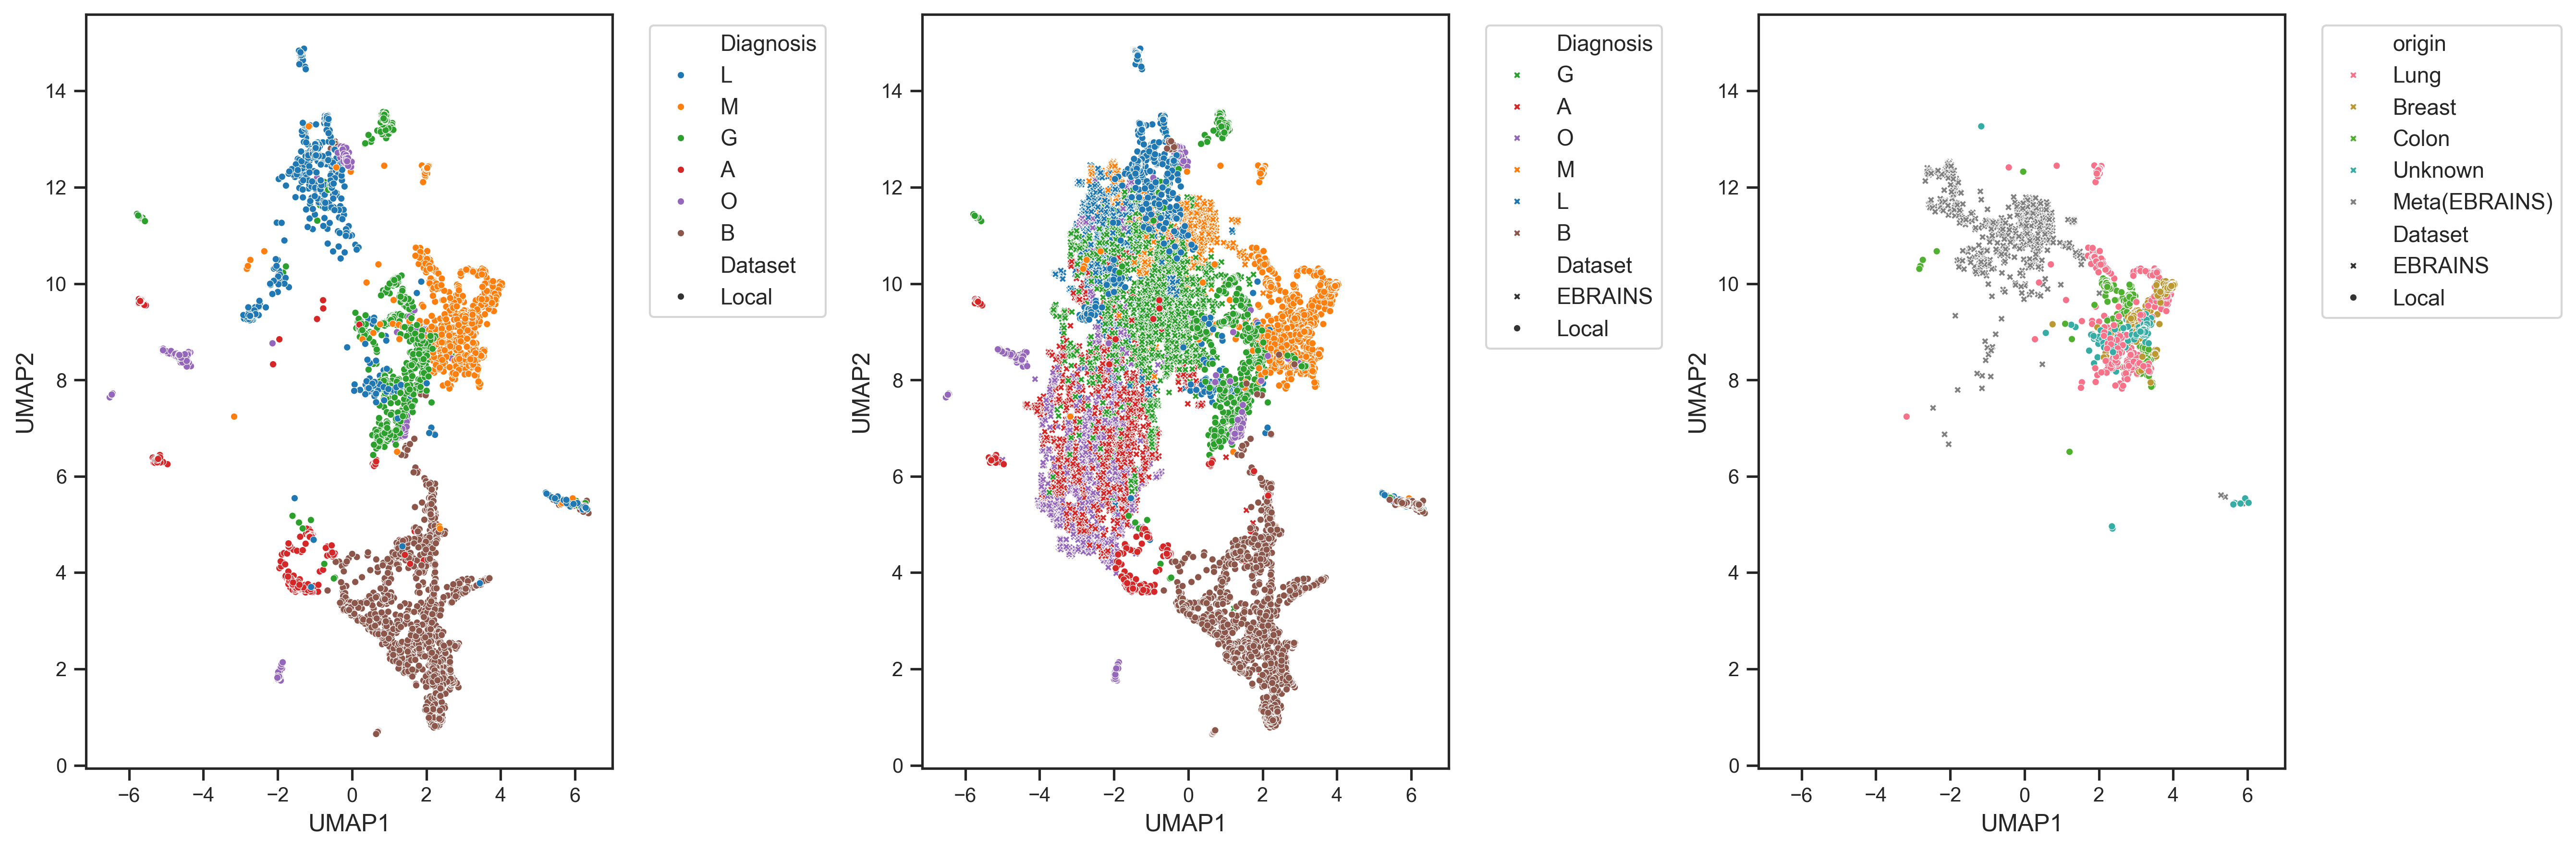

In [5]:
# VIT-L(FT)
cluster(
    'out/compare/LMGAOB/fold5_0/frozen_baseline-vit_500/integrated_umap_embeddings.xlsx',
    mode = 'multi',
)

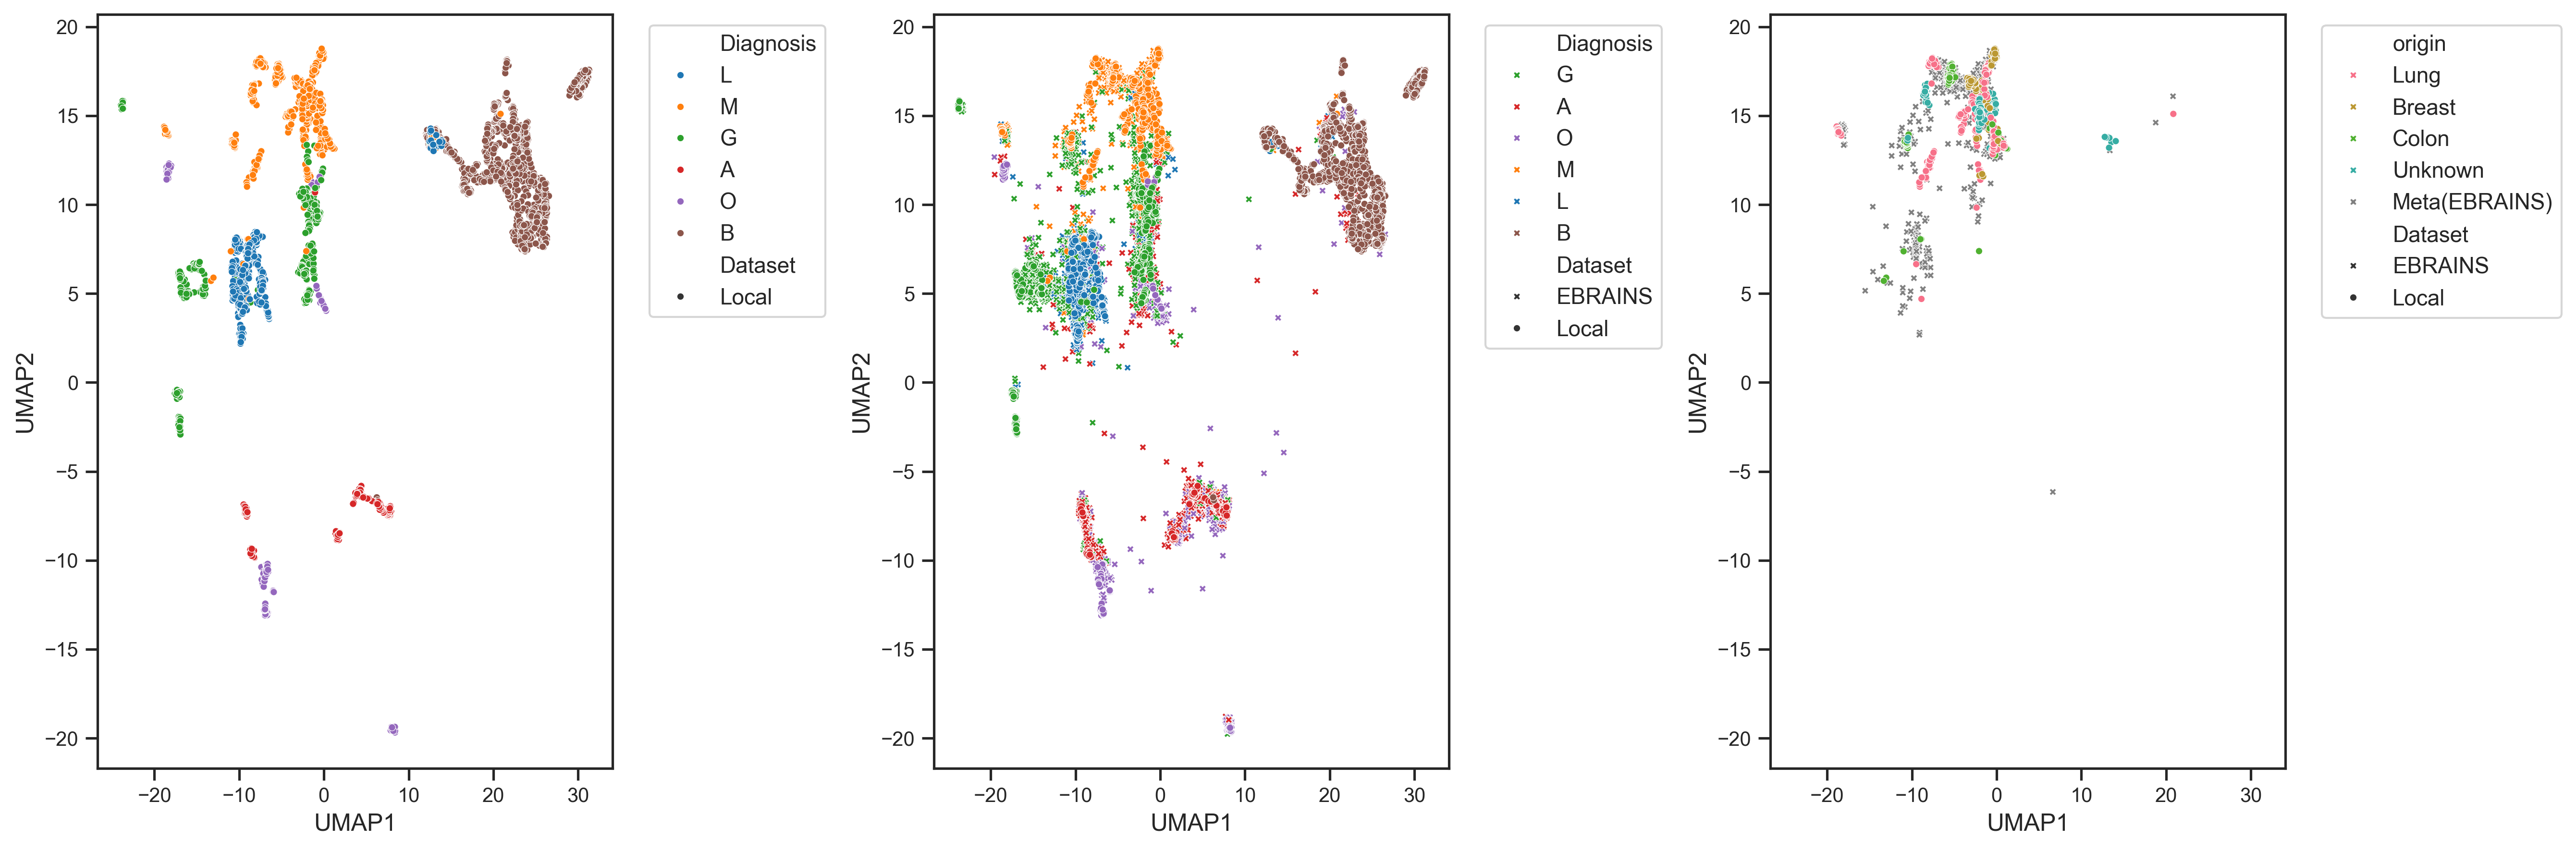

In [9]:
# VIT-L(FT)
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-vit_500/integrated_umap_embeddings.xlsx',
    mode = 'multi',
)

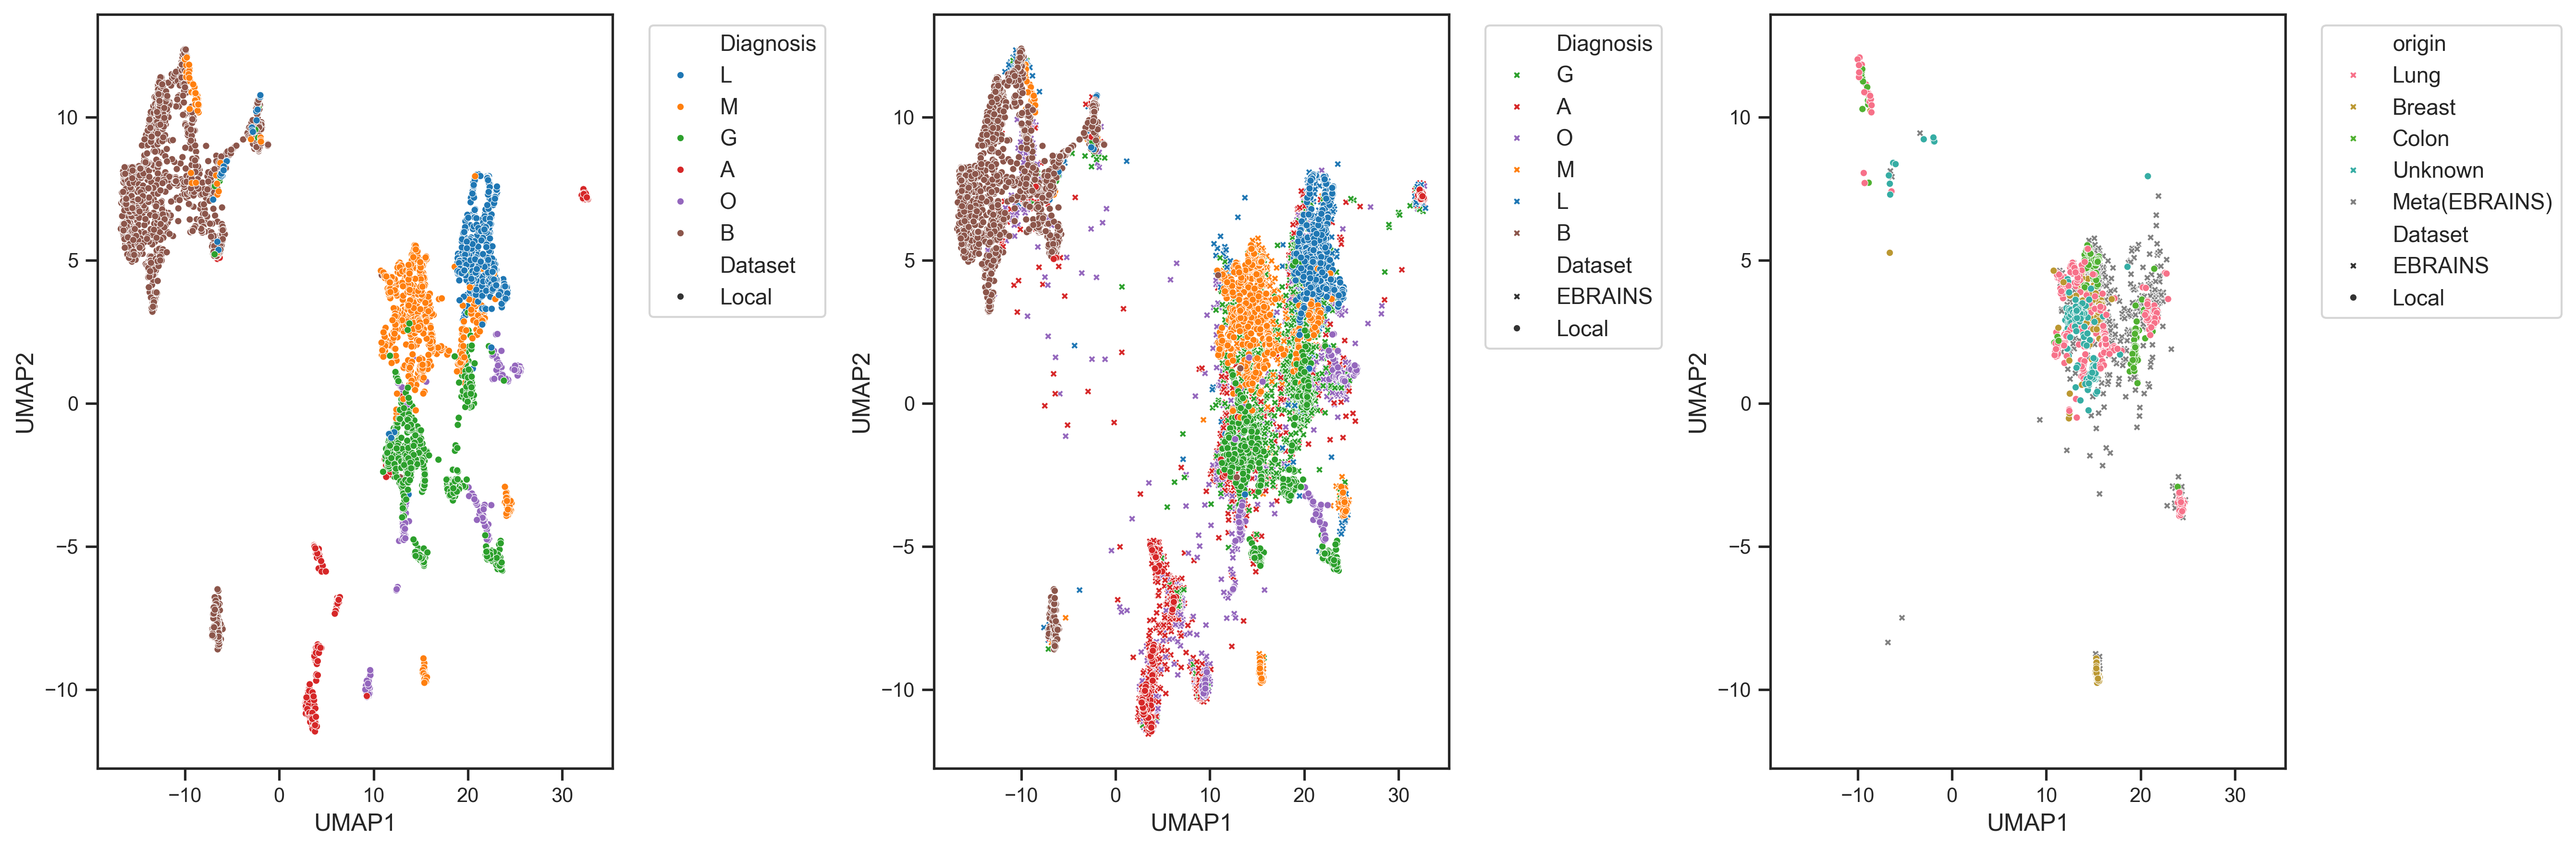

In [8]:
# VIT-L(RI)
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_random-vit_500/integrated_umap_embeddings.xlsx',
    mode = 'multi',
)

In [ ]:
# VIT-L(RI)
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_random-vit_500/integrated_umap_embeddings.xlsx',
    mode = 'multi',
)